In [2]:
from keras.datasets import mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = np.array([train_image.flatten() for train_image in train_images])

2023-04-10 17:15:19.535653: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 17:15:20.238036: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:15:20.877697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:15:20.883153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 17:15:26.252173: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
train_labels.shape

(60000,)

In [4]:
test_labels.shape

(10000,)

In [13]:
from PIL import Image

display(Image.fromarray(train_images[5].reshape(28, -1), 'L'))
type(train_images)

numpy.ndarray

In [14]:
from math import exp

def sigmoid(x: float | np.floating) -> float:
    return 1 / (1 + exp(-x))

def sigmoid_derivative(sigm: float) -> float:
    return sigm * (1 - sigm)

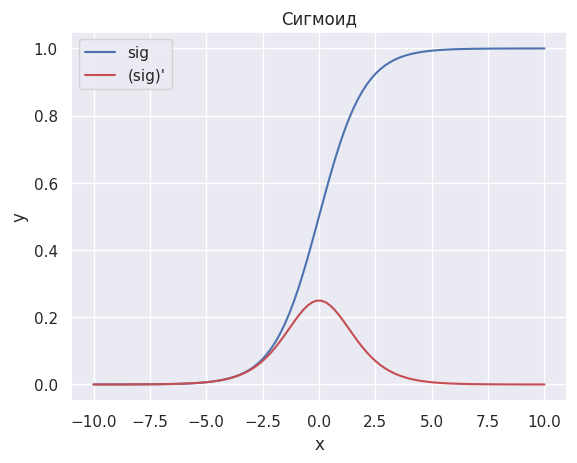

In [15]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

x = np.linspace(-10, 10, 100)
y = [sigmoid(x) for x in x]
dy = [sigmoid_derivative(sigmoid(x)) for x in x]

fig, ax = plt.subplots()

ax.set_title('Сигмоид')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, color = 'b', label = 'sig');
ax.plot(x, dy, color = 'r', label = '(sig)\'');
ax.legend()

### Нейрон

In [16]:
import random
import numpy as np

class Neuron:

    def __init__(self, size: tuple[int, int]):
        self.init_weights(size)

    def init_weights(self, size: tuple[int, int], min: float = -0.03, max: float = 0.03):
        self._weights = np.random.uniform(min, max, size).flatten()
        self._bias = np.random.uniform(min, max)

    def correct_weights(self, inputs: np.ndarray, correction: float): 
        self._weights += inputs * correction
        self._bias += correction

    def get_weights(self):
        return self._weights

    def compute(self, inputs: np.ndarray) -> float:
        weighted_sum = self._weighted_sum(inputs)
        output = self._activation(weighted_sum)

        return output

    def _activation(self, w_sum: float) -> float:
        return sigmoid(w_sum)

    
    def _weighted_sum(self, inputs: np.ndarray) -> float:
        return np.dot(inputs, self._weights) + self._bias


### Вывод информации об обучении (графики функции потерь)

In [17]:
class PlotData:
    def __init__(
            self, 
            data: list, 
            title: str, 
            scalex: str = 'linear', 
            scaley: str = 'linear', 
            linestyle: str = '-', 
            linewidth: float = 1, 
            color: str = 'b',
            marker: str = '',
            markeredgewidth: float = 1,
            alpha: float = 1,
            markersize: float = 5):
        self.data = data
        self.title = title
        self.scalex = scalex
        self.scaley = scaley
        self.style = linestyle
        self.linewidth = linewidth
        self.color = color
        self.marker = marker
        self.markeredgewidth = markeredgewidth
        self.alpha = alpha
        self.markersize = markersize

def plot_weights_and_success(
        final_weights: dict[int, np.ndarray],
        graphs_and_titles: list[PlotData]
        ):
    
    import matplotlib.pyplot as plt
    colormap = 'coolwarm'

    fig, hmaps = plt.subplots(1, len(final_weights))

    import matplotlib.colors

    print('Тепловая карта весов: ')
    for (label, weights), axis in zip(final_weights.items(), hmaps):
        colnorm = matplotlib.colors.CenteredNorm(vcenter=0)
        axis.imshow(weights, cmap=colormap, norm=colnorm)
        
        axis.tick_params(
            axis='both',
            labelbottom = False,
            labelleft = False
        )
        axis.set_title(str(label))
        axis.grid(False)
    
    fig.tight_layout()

    fig, graphs = plt.subplots(len(graphs_and_titles), 1)

    for axis, pdata in zip(graphs, graphs_and_titles):
        axis.tick_params(axis='y', which='minor')
        from matplotlib.ticker import FormatStrFormatter
        axis.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
        pdata.data.insert(0, 0)
        axis.plot(
            [x for x in range(len(pdata.data))], pdata.data, 
            linestyle = pdata.style, 
            linewidth = pdata.linewidth, 
            color = pdata.color,
            marker = pdata.marker, 
            alpha = pdata.alpha, 
            markersize = pdata.markersize, 
            markeredgewidth = pdata.markeredgewidth
        )
        axis.set_xscale(pdata.scalex) # type: ignore
        axis.set_yscale(pdata.scaley) # type: ignore
        axis.set_title(pdata.title)
    fig.tight_layout()

    plt.show()

### Перцептрон

In [18]:
from tqdm.notebook import tqdm

class PerceptronGradDesсend:

    def __init__(self, size: tuple[int, int] = (28, 28)) -> None:
        self._size = size
        self._neurons = {label: Neuron(size=size) for label in range(10)}
        self.THRESHOLD = 0.5
        self._error_threshold = 0.01


    def process_neurons(self, inputs: np.ndarray) ->  dict[int, float]:
        return {label:neuron.compute(inputs) for label, neuron in self._neurons.items()}
    
    def calculate_error(self, output: float, neuron_label: int, true_label: int) -> float:
        if neuron_label == true_label:
            return 1 - output
        else:
            return 0 - output

    def correct_weights(self, corrections: dict[int, float], inputs: np.ndarray):
        for label, correction in corrections.items():
            self._neurons[label].correct_weights(inputs, correction)
        pass


    def train_epochs_new(self, learning_rate: float, epochs: int, images: np.ndarray, labels: np.ndarray):
        dataset_size = labels.shape[0]
        # наборы данных для построения графиков
        loss_epochs = []
        loss_iterations = []
        successes_epochs = []
        success_iterations = []

        # weight_correction = {label: 0.0 for label in range(10)}

        for _ in tqdm(range(epochs), 'Эпохи'):
            epoch_train_count_total = 0
            epoch_train_count_success = 0
            loss_epoch = 0

            for image, t_label in tqdm(zip(images, labels), 'Итерации', total=dataset_size, leave=False):
                squared_error_sum = 0
                for n_label, neuron in self._neurons.items():
                    output = neuron.compute(image)
                    error = self.calculate_error(output, n_label, t_label)
                    delta = -error * sigmoid_derivative(output)
                    weight_correction = -learning_rate * delta
                    neuron.correct_weights(image, weight_correction)

                    squared_error_sum += error**2
                    epoch_train_count_success += (n_label == t_label) and output > 0.5
                
                epoch_train_count_total += 1
                loss_current = (0.5 * squared_error_sum) / dataset_size
                success_iterations.append(epoch_train_count_success/epoch_train_count_total)
                loss_iterations.append(loss_current)
                loss_epoch += loss_current
            loss_epochs.append(loss_epoch)
            successes_epochs.append(epoch_train_count_success/epoch_train_count_total)

        final_weights = {label:neuron.get_weights().reshape(self._size[0], -1) for label, neuron in self._neurons.items()}

        plot_weights_and_success(
            final_weights = final_weights,
            graphs_and_titles=[
                PlotData(loss_iterations, 'Ошибки с каждой итерацией', scalex='linear', scaley='log',linestyle='-', linewidth=0.1),
                PlotData(loss_epochs, 'Ошибки с каждой эпохой', marker='.'),
                PlotData(success_iterations, 'Успех с каждой итерацией', scalex='linear'),
                PlotData(successes_epochs, 'Успех с каждой эпохой', marker='.', color = 'r')
            ]
        )

    def train_loss_current(self, learning_rate: float, loss_threshold: float, images: np.ndarray, labels: np.ndarray):
        dataset_size = labels.shape[0]
        # наборы данных для построения графиков
        loss_epochs = []
        loss_iterations = []
        successes_epochs = []
        success_iterations = []

        weight_correction = {label: 0.0 for label in range(10)}

        loss_current = 1

        while loss_current > loss_threshold:
            epoch_train_count_total = 0
            epoch_train_count_success = 0
            loss_epoch = 0

            for image, t_label in tqdm(zip(images, labels), 'Итерации', total=dataset_size, leave=False):
                squared_error_sum = 0
                for n_label, neuron in self._neurons.items():
                    output = neuron.compute(image)
                    error = self.calculate_error(output, n_label, t_label)
                    delta = -error * sigmoid_derivative(output)
                    weight_correction = -learning_rate * delta
                    neuron.correct_weights(image, weight_correction)

                    squared_error_sum += error**2
                    epoch_train_count_success += (n_label == t_label) and error <= 0.5

                epoch_train_count_total += 1
                success_iterations.append(epoch_train_count_success/epoch_train_count_total)

                loss_current = (0.5 * squared_error_sum) / dataset_size
                loss_iterations.append(loss_current)
                loss_epoch += loss_current
                if loss_current <= loss_threshold:
                    break

            loss_epochs.append(loss_epoch)
            successes_epochs.append(epoch_train_count_success/epoch_train_count_total)

        final_weights = {label:neuron.get_weights().reshape(self._size[0], -1) for label, neuron in self._neurons.items()}

        plot_weights_and_success(
            final_weights = final_weights,
            graphs_and_titles=[
                PlotData(loss_iterations, 'Ошибки с каждой итерацией', scalex='linear', scaley='log',linestyle='-', linewidth=0.1, color='r'),
                PlotData(loss_epochs, 'Ошибки с каждой эпохой', marker='.'),
                PlotData(success_iterations, 'Успех с каждой итерацией', scalex='linear'),
                PlotData(successes_epochs, 'Успех с каждой эпохой', marker='.')
            ]
        )

    def train_loss_total(self, learning_rate: float, loss_threshold: float, images: np.ndarray, labels: np.ndarray):
        dataset_size = labels.shape[0]
        # наборы данных для построения графиков
        loss_epochs = []
        loss_iterations = []
        successes_epochs = []
        success_iterations = []

        weight_correction = {label: 0.0 for label in range(10)}

        loss_epoch = 1

        while loss_epoch > loss_threshold:
            epoch_train_count_total = 0
            epoch_train_count_success = 0
            loss_epoch = 0

            for image, t_label in tqdm(zip(images, labels), 'Итерации', total=dataset_size, leave=False):
                error_sum_iter = 0
                for n_label, neuron in self._neurons.items():
                    output = neuron.compute(image)
                    error = self.calculate_error(output, n_label, t_label)
                    delta = -error * sigmoid_derivative(output)
                    weight_correction = -learning_rate * delta
                    neuron.correct_weights(image, weight_correction)

                    error_sum_iter += error**2
                    epoch_train_count_success += (n_label == t_label) and error <= 0.5 # только правильно распознанные цифры считаются

                epoch_train_count_total += 1
                success_iterations.append(epoch_train_count_success/epoch_train_count_total)
                loss_current = (0.5 * error_sum_iter) / dataset_size
                loss_iterations.append(loss_current)
                loss_epoch += loss_current

            successes_epochs.append(epoch_train_count_success/epoch_train_count_total)
            loss_epochs.append(loss_epoch)
            if loss_epoch <= loss_threshold:
                break

        final_weights = {label:neuron.get_weights().reshape(self._size[0], -1) for label, neuron in self._neurons.items()}

        plot_weights_and_success(
            final_weights = final_weights,
            graphs_and_titles=[
                PlotData(loss_iterations, 'Ошибки с каждой итерацией', scalex='linear', scaley='log',linestyle='-', linewidth=0.1),
                PlotData(loss_epochs, 'Ошибки с каждой эпохой', marker='.', color='r'),
                PlotData(success_iterations, 'Успех с каждой итерацией', scalex='linear'),
                PlotData(successes_epochs, 'Успех с каждой эпохой', marker='.')
            ]
        )


    def train_loss_converge(self, learning_rate: float, loss_delta: float, streak: int,  images: np.ndarray, labels: np.ndarray):
        dataset_size = labels.shape[0]
        loss_epochs = []
        loss_iterations = []
        successes_epochs = []
        success_iterations = []

        weight_correction = {label: 0.0 for label in range(10)}

        streak_remains = streak
        loss_previous = 1

        while streak_remains > 0:
            epoch_train_count_total = 0
            epoch_train_count_success = 0
            loss_epoch = 0

            for image, t_label in tqdm(zip(images, labels), 'Итерации', total=dataset_size, leave=False):
                squared_error_sum = 0
                for n_label, neuron in self._neurons.items():
                    output = neuron.compute(image)
                    error = self.calculate_error(output, n_label, t_label)
                    delta = -error * sigmoid_derivative(output)
                    weight_correction = -learning_rate * delta
                    neuron.correct_weights(image, weight_correction)

                    squared_error_sum += error**2
                    epoch_train_count_success += (n_label == t_label) and error <= 0.5 # только правильно распознанные цифры считаются

                epoch_train_count_total += 1
                success_iterations.append(epoch_train_count_success/epoch_train_count_total)
                loss_current = (0.5 * squared_error_sum) / dataset_size
                loss_iterations.append(loss_current)
                loss_epoch += loss_current

            

            successes_epochs.append(epoch_train_count_success/epoch_train_count_total)
            loss_epochs.append(loss_epoch)
            if abs(loss_epoch - loss_previous) <= loss_delta:
                streak_remains -= 1
            else:
                streak_remains = streak
            loss_previous = loss_epoch

        final_weights = {label:neuron.get_weights().reshape(self._size[0], -1) for label, neuron in self._neurons.items()}

        plot_weights_and_success(
            final_weights = final_weights,
            graphs_and_titles=[
                PlotData(loss_iterations, 'Ошибки с каждой итерацией', scalex='linear', scaley='log',linestyle='-', linewidth=0.1),
                PlotData(loss_epochs, 'Ошибки с каждой эпохой', marker='.', color='r'),
                PlotData(success_iterations, 'Успех с каждой итерацией', scalex='linear'),
                PlotData(successes_epochs, 'Успех с каждой эпохой', marker='.')
            ]
        )

    def test(self, images: np.ndarray, labels: np.ndarray):
        total_count = labels.shape[0]
        correct_count = 0

        for image, label in zip(images, labels):
            inputs = image.flatten()
            outputs = self.process_neurons(inputs)
            predicted_number = max(outputs, key=outputs.get) # type: ignore
            value = max(outputs.values())
            
            if predicted_number == label and value > 0.5:
                correct_count += 1

        accuracy = correct_count/total_count
        print(f'Угадано изображений: {correct_count}/{total_count}')
        print(f'Точность классификации: {round(accuracy, 2)}')



### Критерий: Ошибка не меняется

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


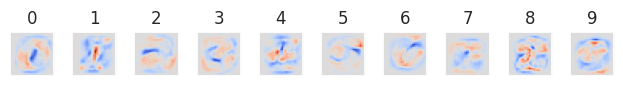

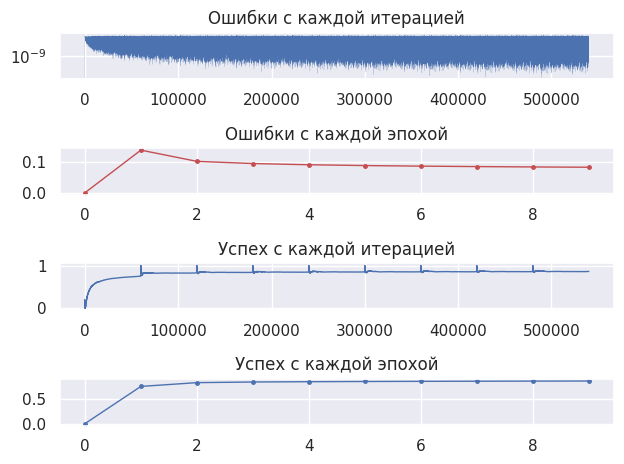

Угадано изображений: 8592/10000
Точность классификации: 0.86


In [19]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_converge(
    learning_rate = 0.01,
    loss_delta = 0.001, 
    streak = 1, 
    images = train_images/255, 
    labels = train_labels
)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


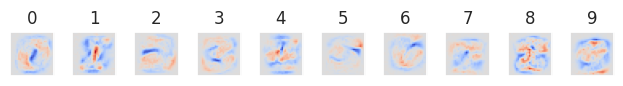

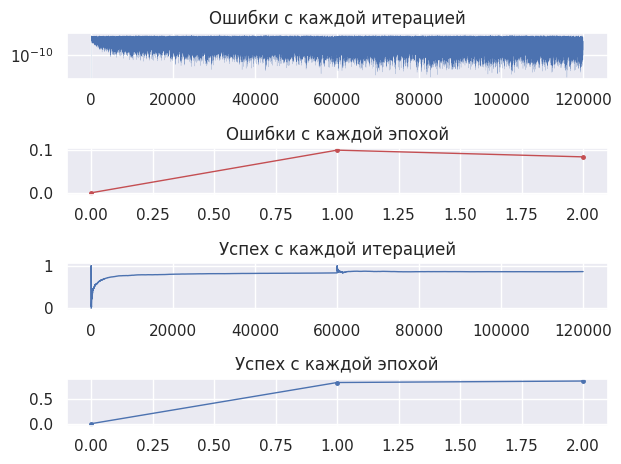

Угадано изображений: 8438/10000
Точность классификации: 0.84


In [20]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_converge(0.1, 0.1, 1, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


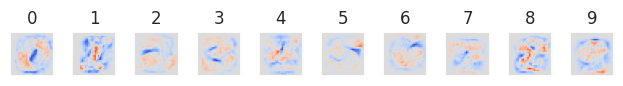

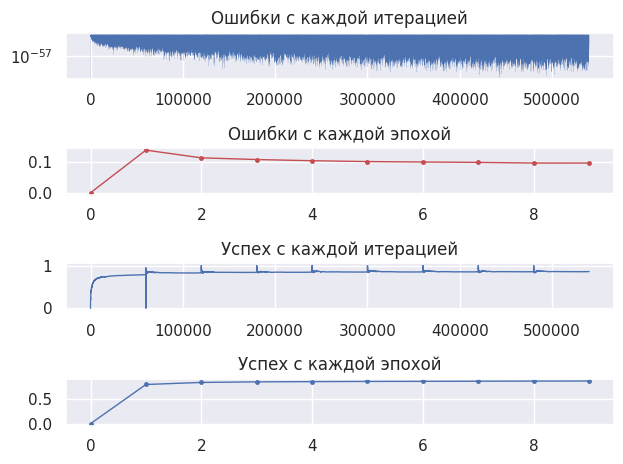

Угадано изображений: 8664/10000
Точность классификации: 0.87


In [21]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_converge(1, 0.001, 1, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

### Критерий: *Общая* ошибка меньше порогового значения

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


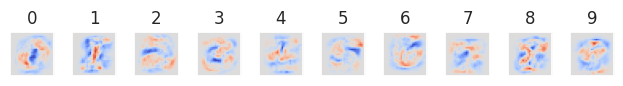

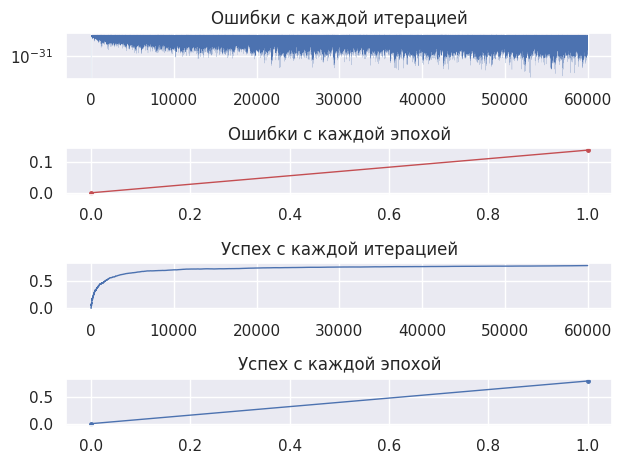

Угадано изображений: 8164/10000
Точность классификации: 0.82


In [22]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_total(1, 0.5, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


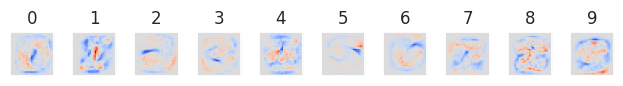

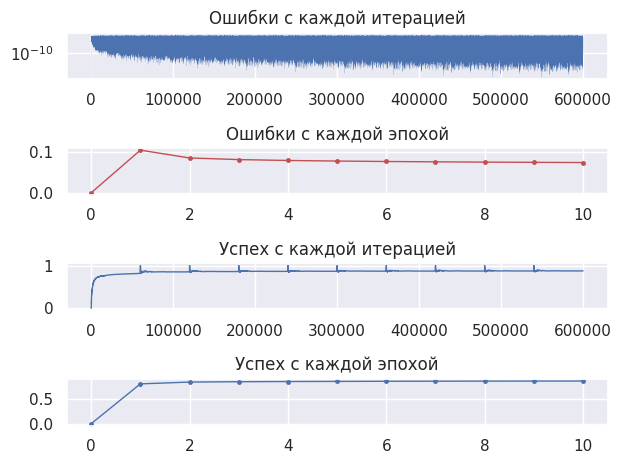

Угадано изображений: 8680/10000
Точность классификации: 0.87


In [23]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_total(0.05, 0.075, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


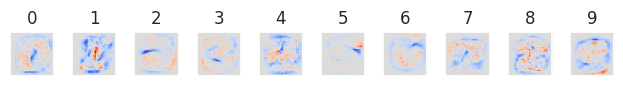

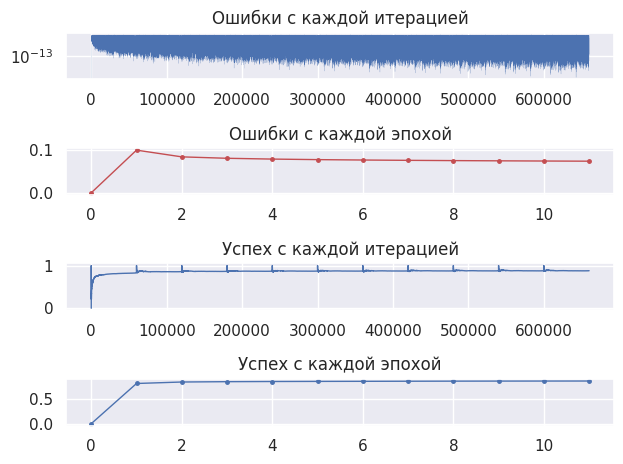

Угадано изображений: 8655/10000
Точность классификации: 0.87


In [24]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_total(0.1, 0.075, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


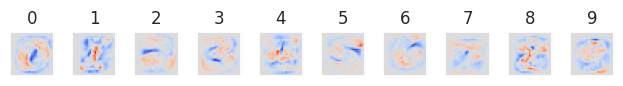

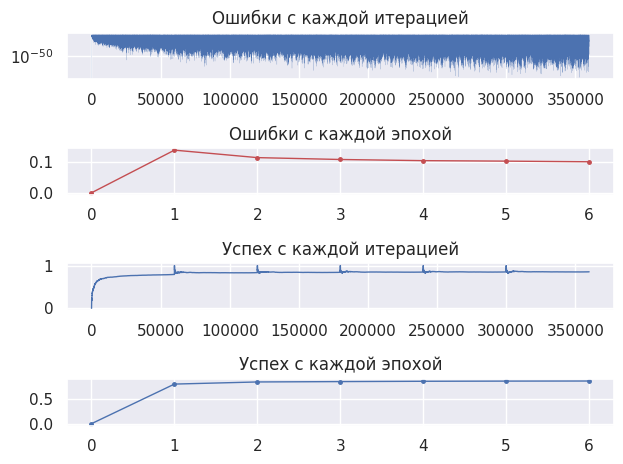

Угадано изображений: 8559/10000
Точность классификации: 0.86


In [25]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_total(1, 0.1, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

### Критерий: *Текущая* ошибка меньше порогового

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


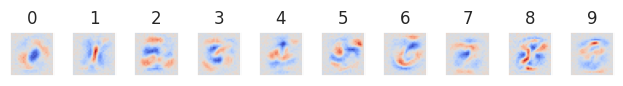

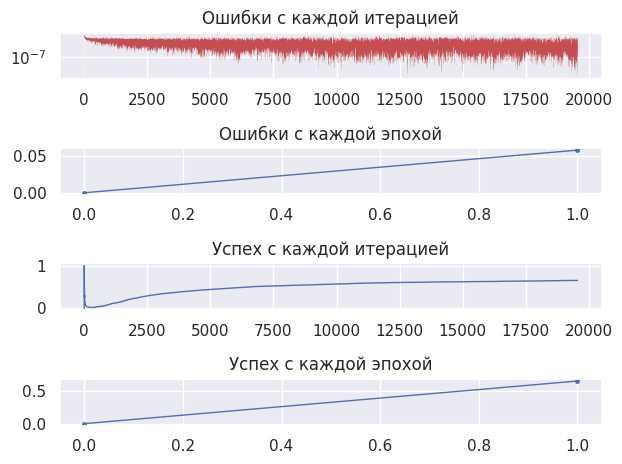

Угадано изображений: 7765/10000
Точность классификации: 0.78


In [26]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_current(0.01, 1e-9, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


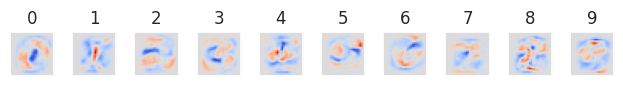

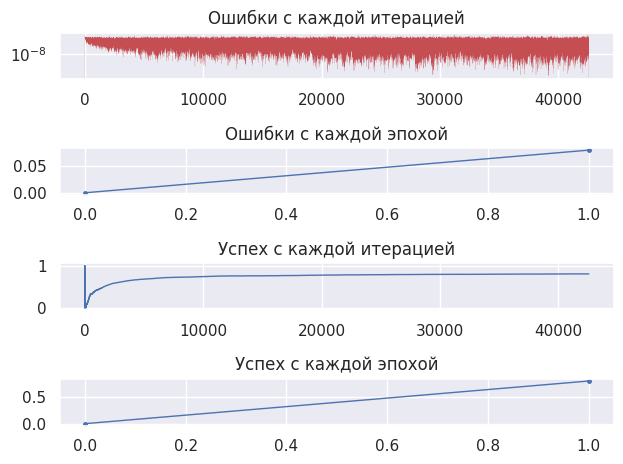

Угадано изображений: 8358/10000
Точность классификации: 0.84


In [27]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_current(0.05, 1e-12, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


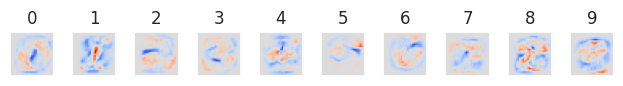

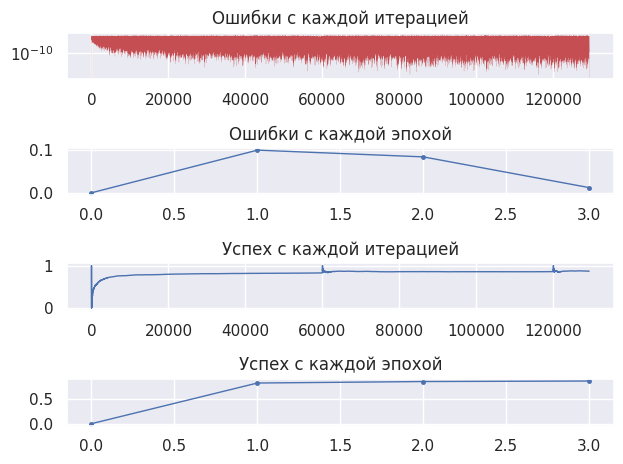

Угадано изображений: 8577/10000
Точность классификации: 0.86


In [28]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_current(0.1, 1e-17, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


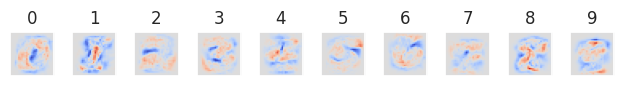

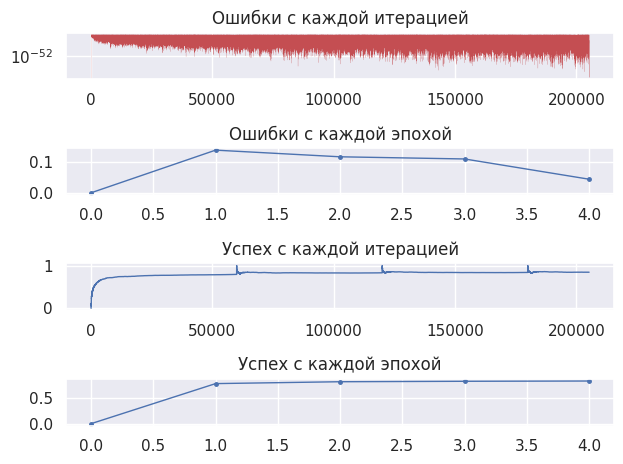

Угадано изображений: 8505/10000
Точность классификации: 0.85


In [29]:
loss_current = PerceptronGradDesсend()

loss_current.train_loss_current(1, 1e-100, train_images/255, train_labels)
loss_current.test(test_images/255, test_labels)

### Критерий: Количество эпох

Эпохи:   0%|          | 0/2 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


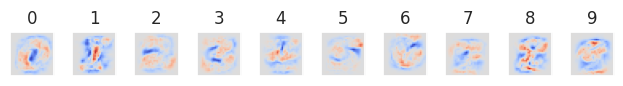

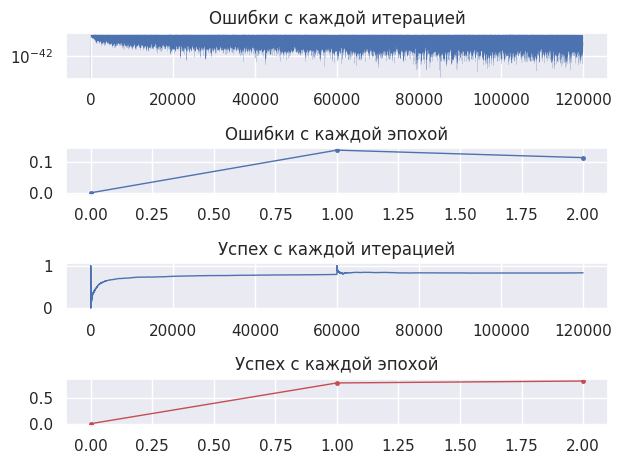

Угадано изображений: 8350/10000
Точность классификации: 0.83


In [37]:
epochs = PerceptronGradDesсend()

epochs.train_epochs_new(1, 2, train_images/255, train_labels)
epochs.test(test_images/255, test_labels)

Эпохи:   0%|          | 0/4 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


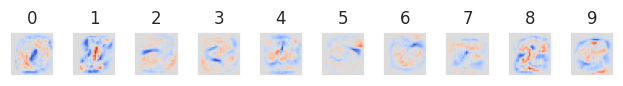

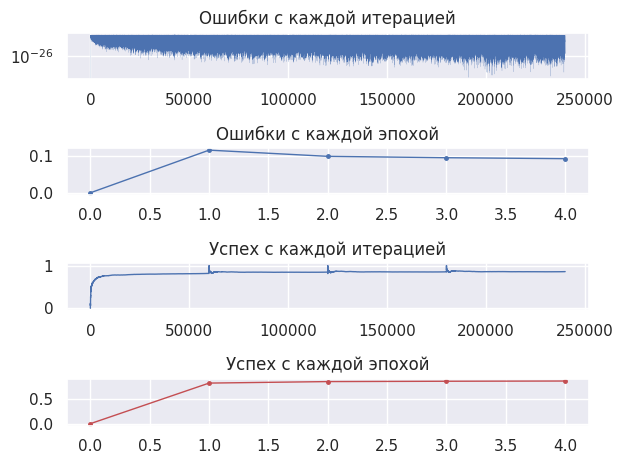

Угадано изображений: 8412/10000
Точность классификации: 0.84


In [31]:
epochs = PerceptronGradDesсend()

epochs.train_epochs_new(0.5, 4, train_images/255, train_labels)
epochs.test(test_images/255, test_labels)

Эпохи:   0%|          | 0/5 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


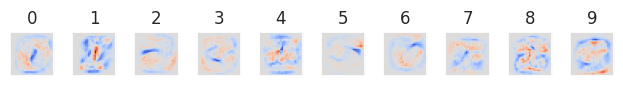

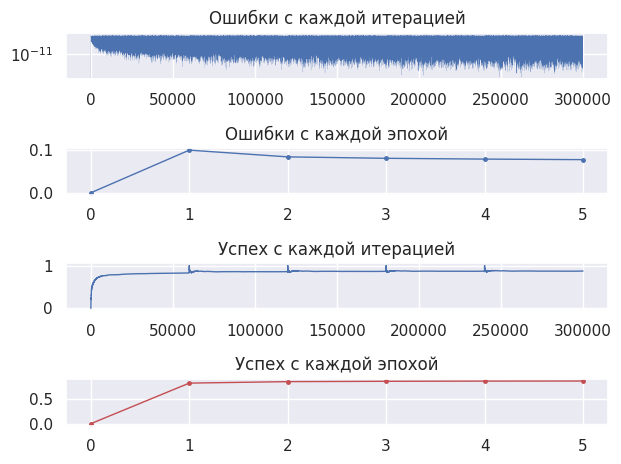

Угадано изображений: 8565/10000
Точность классификации: 0.86


In [32]:
epochs = PerceptronGradDesсend()

epochs.train_epochs_new(0.1, 5, train_images/255, train_labels)
epochs.test(test_images/255, test_labels)

Эпохи:   0%|          | 0/8 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


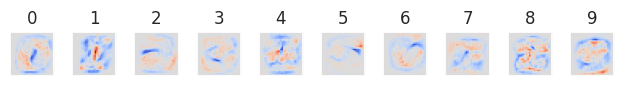

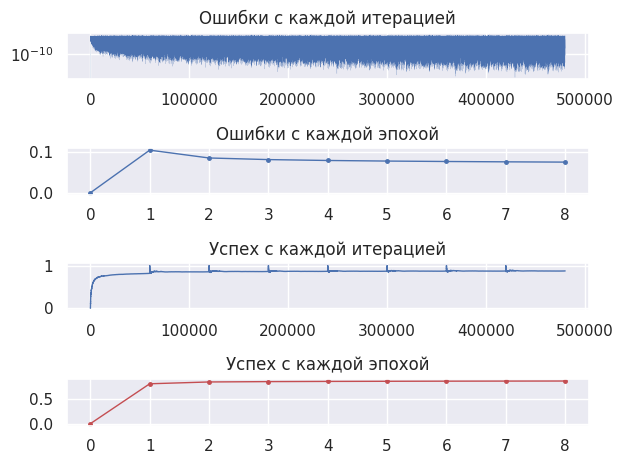

Угадано изображений: 8657/10000
Точность классификации: 0.87


In [33]:
epochs = PerceptronGradDesсend()

epochs.train_epochs_new(0.05, 8, train_images/255, train_labels)
epochs.test(test_images/255, test_labels)

Эпохи:   0%|          | 0/10 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Итерации:   0%|          | 0/60000 [00:00<?, ?it/s]

Тепловая карта весов: 


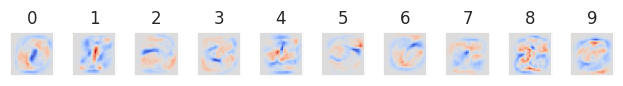

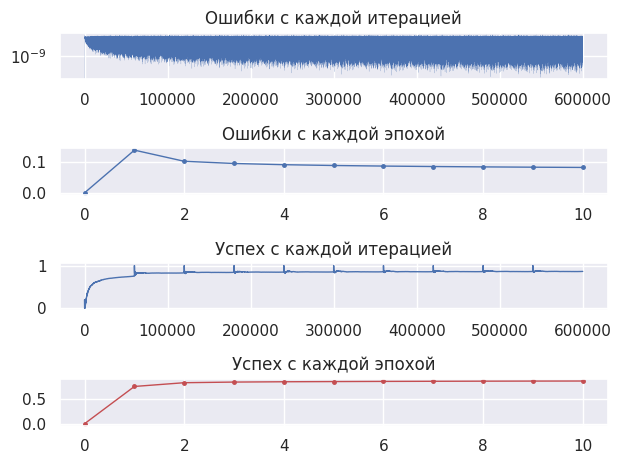

Угадано изображений: 8605/10000
Точность классификации: 0.86


In [34]:
epochs = PerceptronGradDesсend()

epochs.train_epochs_new(0.01, 10, train_images/255, train_labels)
epochs.test(test_images/255, test_labels)